# Backtesting d'une Stratégie de Trading Algorithmique Basée sur un Modèle LSTM Multivarié 

Bienvenue dans ce Notebook où nous allons réaliser un backtest vectorisé d'une stratégie de trading algorithmique sophistiquée. Notre approche combine les prédictions d'un modèle LSTM multivarié avec une série d'autres indicateurs fondés sur des variables macroéconomiques et fondamentales, ainsi que d'autres prédictions issues de modèles de Machine Learning. Notre univers de trading se compose des paires Forex les plus liquides, nous permettant de bénéficier d'une grande flexibilité et d'une facilité d'exécution.

Le modèle LSTM multivarié est un type particulier de réseau neuronal récurrent (RNN) qui utilise une structure de mémoire à long terme pour mieux appréhender les dépendances temporelles à long terme dans les séries de données. Dans notre cas, ce modèle sert à prédire les mouvements de prix futurs sur la base de séries de données historiques.

Les autres indicateurs que nous utilisons sont basés sur des variables macroéconomiques et fondamentales. Nous combinons ces indicateurs avec les prédictions de notre modèle LSTM dans le cadre d'une approche de trading algorithmique hybride.

En outre, nous utilisons également d'autres modèles de Machine Learning pour générer des prédictions supplémentaires. Ces modèles sont formés sur diverses autres caractéristiques liées au marché et sont utilisés pour compléter les prédictions de notre modèle LSTM.

En combinant toutes ces prédictions, nous créons une stratégie de trading qui est non seulement capable de prédire les mouvements futurs des prix, mais qui est également capable d'ajuster ces prédictions en fonction des conditions économiques actuelles et prévues.

L'objectif de ce Notebook est de réaliser un backtest vectorisé de cette stratégie pour évaluer sa performance sur des données historiques. Le backtesting vectorisé est une méthode rapide et efficace pour évaluer les performances historiques d'une stratégie de trading. Nous espérons que ce Notebook vous aidera à comprendre comment implémenter et évaluer une telle stratégie de trading algorithmique.

Nous allons maintenant commencer par importer les bibliothèques nécessaires et charger nos données.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm, spearmanr, pearsonr

In [2]:
conn = sqlite3.connect('datas.db')

cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
for table in cur.fetchall():
    print(table[0])

ma_ridge
rsi
rates
BOT
Inflation
first_lstm_predictions
first_lstm_predictions_300lag
commodities research
commodities_research
actuals
AR5_GARCH
markowitz_pf_returns
equaly_weighted_pf_returns


In [3]:
rsi = pd.read_sql_query('SELECT symbol, time AS date, target, rsi_14 FROM rsi', conn).set_index(['symbol', 'date'])
lstm = (pd
        .read_sql_query('SELECT ticker AS symbol, date, prediction, actual FROM first_lstm_predictions_300lag', conn)
        .set_index(['symbol', 'date']))
rates = pd.read_sql_query('SELECT * FROM rates', conn).rename({'time': 'date', 'returns': 'actual'}, axis=1).set_index(['symbol', 'date'])
ma_ridge = pd.read_sql_query('SELECT * FROM ma_ridge', conn).rename({'time': 'date'}, axis=1).set_index(['symbol', 'date'])
bot = pd.read_sql_query('SELECT * FROM BOT', conn).rename({'time': 'date'}, axis=1).set_index(['symbol', 'date'])
inflation = pd.read_sql_query('SELECT * FROM Inflation', conn).rename({'time': 'date'}, axis=1).set_index(['symbol', 'date'])

commodities = (pd.read_sql_query('SELECT * FROM commodities_research', conn)
               .rename({'time': 'date'}, axis=1)
               .set_index('date')
               .stack()
               .swaplevel()
               .sort_index()
               .to_frame()
               .rename({0: 'pred'}, axis=1))

actuals = (pd.read_sql_query('SELECT * FROM actuals', conn)
               .rename({'time': 'date'}, axis=1)
               .set_index('date')
               .stack()
               .swaplevel()
               .sort_index()
               .to_frame()
               .rename({0: 'actual'}, axis=1))

ar_garch = pd.read_sql_query('SELECT * FROM AR5_GARCH', conn).rename({'level_1': 'date'}, axis=1).set_index(['symbol', 'date'])

In [4]:
thr = 0.95
mappage = dict(ar_garch.groupby(level=0).quantile(0.5).volatility)
ar_garch['volatility_filter'] = ar_garch.volatility > (ar_garch
                                                       .index
                                                       .get_level_values('symbol')
                                                       .map(mappage)
                                                       .astype(int))

In [7]:
commodities = commodities.join(actuals)

In [8]:
import pickle
with open('weights.pkl', 'rb') as f:
    weights = pickle.load(f)

Ce morceau de code génère un histogramme de la distribution des valeurs de l'Indice de Force Relative (RSI) en utilisant la fonction sns.histplot(). En plus de l'histogramme, un tracé de la densité de probabilité (Kernel Density Estimation - KDE) est superposé pour mieux visualiser la forme de la distribution.

La ligne de code `mean = rsi.rsi_14.mean()` calcule la moyenne de la colonne rsi_14 tandis que std_dev = `rsi.rsi_14.std()` calcule l'écart type de cette même colonne. Ensuite, `skewness = skew(rsi.rsi_14)` et `kurt = kurtosis(rsi.rsi_14)` calculent respectivement l'asymétrie (skewness) et l'aplatissement (kurtosis) de la distribution des valeurs de RSI.

Le code `normal = norm.pdf(x, mean, std_dev)` génère une distribution normale basée sur la moyenne et l'écart type du RSI. Cette distribution normale est ensuite tracée sur le graphique avec la fonction `plt.plot()`.

Une boîte de texte est ajoutée au graphique avec `plt.text()` pour afficher les statistiques de la distribution : la moyenne, l'écart type, l'asymétrie et l'aplatissement.

Finalement, le code génère le graphique avec `plt.show()`.

À l'issue de ces manipulations, nous observons que la distribution du RSI est très proche d'une loi normale. Cela signifie que la majorité des valeurs du RSI sont proches de la moyenne, avec peu de valeurs extrêmes. Cette caractéristique est importante dans le cadre du trading, car elle suggère que le RSI est un indicateur stable et prévisible pour cette série de données.

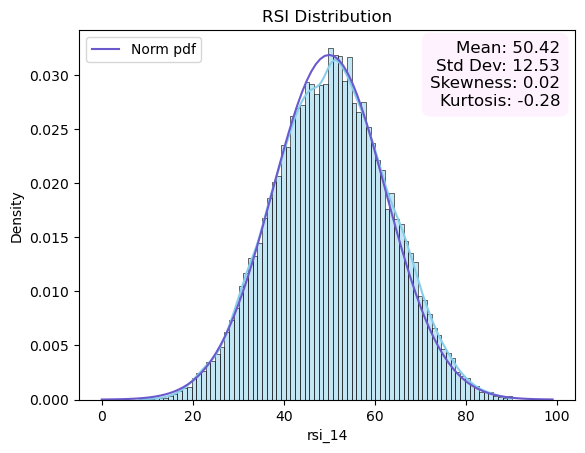

In [9]:
sns.histplot(data=rsi, x='rsi_14', kde=True, stat='density', color='skyblue')
mean = rsi.rsi_14.mean()
std_dev = rsi.rsi_14.std()
skewness = skew(rsi.rsi_14)
kurt = kurtosis(rsi.rsi_14)
x = np.linspace(0, 100, 100)
normal = norm.pdf(x, mean, std_dev)
plt.plot(normal, color='slateblue', label='Norm pdf')
bbox_props = dict(boxstyle='round, pad=0.5', fc=(1, 0.9, 1, 0.5), ec='none')
plt.text(x=0.97, y=0.97, transform=plt.gca().transAxes,
         s=f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nSkewness: {skewness:.2f}\nKurtosis: {kurt:.2f}",
         ha='right', va='top', fontsize=12, bbox=bbox_props)

plt.legend(loc=2)

plt.title('RSI Distribution')

plt.show()

In [10]:
inflation['rate_spread'].corr(rates['rate_spread'])

0.11884511871426774

Dans ce code, nous initialisons plusieurs colonnes avec les valeurs 0, 1 et -1. Ces valeurs correspondent respectivement à une absence de signal, un signal d'achat ou un signal de vente. Pour chaque modèle, une condition est établie. Si la condition est satisfaite, le signal sera de 1, sinon de -1.

Par exemple, pour le modèle 'rsi', si 'rsi_14' est supérieur à 50.42, le signal est de vente (-1), sinon il est d'achat (1). Pour le modèle 'lstm', 'rates', 'ma_ridge', 'bot', 'inflation' et 'commodities', si la prédiction ou le taux est supérieur à 0, le signal est d'achat (1), sinon, il est de vente (-1).

En ce qui concerne le modèle 'ar_garch', il suit une logique légèrement différente. Si la 'volatility_filter' est égale à 1 ou si la prédiction est supérieure à 0, le signal est de vente (-1). Si la 'volatility_filter' est égale à 1 ou si la prédiction est inférieure à 0, le signal est d'achat (1). En cas contraire, le signal est neutre (0).

In [11]:
rsi['rsi_filter'] = np.where(rsi.rsi_14 > 50.42, -1, 1)
lstm['lstm_filter'] = np.where(lstm.prediction > 0, 1, -1)
rates['rates_filter'] = np.where(rates.rate_spread > 0, 1, -1)
ma_ridge['ma_ridge_filter'] = np.where(ma_ridge.predicted > 0, 1, -1)
bot['bot_filter'] = (bot.groupby(level='symbol', group_keys=False)['rate_spread']
                     .transform(lambda x: np.where(x - x.mean() > 0, 1, -1)))
inflation['inf_filter'] = np.where(inflation.rate_spread > 0, 1, 1)
commodities['commodities_filter'] = np.where(commodities['pred'] > 0, 1, -1)

ar_cond = [np.array((ar_garch.volatility_filter == 1) | (ar_garch.predicted > 0)),
           np.array((ar_garch.volatility_filter == 1) | (ar_garch.predicted < 0))]
ar_choices = [-1, 1]
ar_garch['ar_filter'] = np.select(ar_cond, 
                                  ar_choices,
                                  default=0)

Dans ce code, nous calculons différents poids pour les prédictions qui nous intéressent. Ces poids sont dérivés du coefficient d'information, qui est une mesure de la qualité du signal. Bien que ces signaux puissent sembler faibles, il faut rappeler que dans le domaine financier, les prix des actifs tendent à être efficaces (conformément à l'hypothèse d'efficience des marchés ou EMH). Par conséquent, il est généralement très difficile de faire des prédictions précises sur les futurs prix des actifs.

Un aspect à souligner est le terme "facteur alpha". Ce terme provient du Modèle d'évaluation des actifs financiers (MEDAF), où l'alpha est le rendement d'un investissement qui ne peut pas être expliqué par les fluctuations et le bruit du marché. En d'autres termes, il est la performance qui dépasse ce qui pourrait être prévu en fonction du risque inhérent au marché.

Dans ce contexte, notre approche cherche à optimiser ces facteurs alpha, c'est-à-dire à identifier les signaux les plus fiables pour dépasser les rendements du marché. La performance de cette approche est en fait assez bonne, surtout lorsqu'on combine ces différents facteurs alpha.

Nous utilisons la corrélation de Spearman pour calculer le coefficient d'information pour chaque modèle ('lstm', 'rsi', 'rates', 'ma_ridge', 'commodities'). Ensuite, ces coefficients sont stockés dans un dictionnaire.

Finalement, nous transformons les coefficients d'information en poids, en les divisant par leur somme absolue. Cela nous donne les poids relatifs de chaque modèle en fonction de la qualité de leurs signaux, qui sont stockés dans un DataFrame pandas.

In [13]:
ic_dict = {}
keys = dict(zip(['lstm', 'rsi', 'rates', 'ma_ridge', 'commodities'], [lstm, rsi, rates, ma_ridge, commodities]))
for key in keys:
    ic_dict[key] = spearmanr(keys[key].iloc[:, 0], keys[key].iloc[:, 1]).statistic

ic_df = pd.DataFrame(ic_dict, index=['ic']).transpose()
ic_df['weights'] = ic_df.transform(lambda x: np.abs(x) / np.abs(x).sum())

In [14]:
ic_df

,ic,weights
lstm,0.019397,0.244452
rsi,-0.013092,0.165001
rates,0.023501,0.296181
ma_ridge,0.010744,0.135404
commodities,0.012613,0.158963


Ce code effectue plusieurs opérations pour calculer les rendements d'un backtest sur une stratégie d'investissement basée sur plusieurs modèles prédictifs et leurs coefficients d'information correspondants.

Il commence par combiner les signaux générés par plusieurs modèles prédictifs, y compris 'lstm', 'rsi', 'rates', 'ma_ridge' et 'commodities'. Ensuite, ces signaux sont multipliés par les poids relatifs (calculés précédemment à partir des coefficients d'information de chaque modèle).

Un signal final est ensuite calculé en prenant la moyenne des signaux pondérés, puis en utilisant la fonction signe pour obtenir une valeur de -1, 0 ou 1. Cette valeur représente le signal de trading final pour chaque période : vendre, ne rien faire ou acheter.

Les rendements du backtest sont calculés en multipliant ce signal final par les rendements réels. Des frais de transaction sont également pris en compte, et sont déduits chaque fois qu'un changement de position a lieu.

Enfin, deux types de rendements de portefeuille sont calculés : un portefeuille à pondération égale (où chaque actif contribue de manière égale au rendement du portefeuille) et un portefeuille de Markowitz (où chaque actif contribue au rendement du portefeuille en fonction d'une série de poids prédéfinis). Il est important de noter que ces poids ont été calculés ultérieurement en minimisant la variance du portefeuille. Pour ce faire, on a utilisé la matrice de covariance des rendements des actifs du portefeuille, conformément à la théorie moderne du portefeuille.

In [15]:
new_filter = pd.concat([lstm.shift(-1), 
                       rsi['rsi_filter'], 
                       rates['rates_filter'],
                       ma_ridge['ma_ridge_filter'],
                       commodities['commodities_filter']], axis=1).dropna()
for idx in ic_df.index:
    new_filter[[c for c in new_filter.columns if idx in c]] *= ic_df.weights.loc[idx]
new_filter['last_filter'] = np.sign(new_filter[[c for c in new_filter.columns if 'filter' in c]].mean(axis=1))

In [16]:
returns_rescaling = 1000
new_filter.actual /= returns_rescaling
backtest_returns = new_filter['last_filter'] * new_filter.actual

In [17]:
fees = 1e-4
fees_array = np.where(new_filter['last_filter'] != new_filter['last_filter'].shift(1), fees, 0)
backtest_returns -= fees_array

In [18]:
back_mean = backtest_returns.mean()
backtest_returns = backtest_returns.unstack(0).fillna(back_mean)
equaly_weighted_pf_returns = backtest_returns.mean(axis=1)
#Initialisation du vecteur de poids
weights_arr = []
for key in backtest_returns.columns:
    weights_arr.append(weights[key])
markowitz_pf_returns = backtest_returns @ np.array(weights_arr)

Dans ce segment de code, le ratio de Sharpe annuel est calculé pour deux types de portefeuilles : le portefeuille pondéré selon la théorie de Markowitz et le portefeuille équipondéré.

Le ratio de Sharpe est une mesure qui permet d'évaluer le rendement d'un investissement par rapport à sa volatilité. Dans ce cas, le ratio de Sharpe est calculé sans prendre en compte un taux sans risque, c'est-à-dire qu'il se base uniquement sur le rendement du portefeuille et sa volatilité. Un ratio de Sharpe élevé indique généralement une meilleure performance ajustée au risque.

Il est observé ici que le ratio de Sharpe du portefeuille équipondéré est particulièrement élevé. Cela peut s'expliquer par le fait que lors de l'optimisation des poids des actifs dans le portefeuille, l'objectif était de minimiser la variance du portefeuille sans tenir compte de l'espérance de rentabilité. En effet, prendre en compte l'espérance de rentabilité dans l'optimisation peut conduire à du surajustement (ou "overfitting") lors du backtest, rendant les résultats moins fiables pour prédire les performances futures.

In [19]:
print('The markowitz weighted portfolio annual sharpe is {}'
      .format((markowitz_pf_returns.mean() * 252 * 6) / (markowitz_pf_returns.std() * np.sqrt(252 * 6))))
print('The equally weighted portfolio annual sharpe is {}'
      .format((equaly_weighted_pf_returns.mean() * 252 * 6) / (equaly_weighted_pf_returns.std() * np.sqrt(252 * 6))))

The markowitz weighted portfolio annual sharpe is 1.7693735021780044
The equally weighted portfolio annual sharpe is 2.2744775743296044


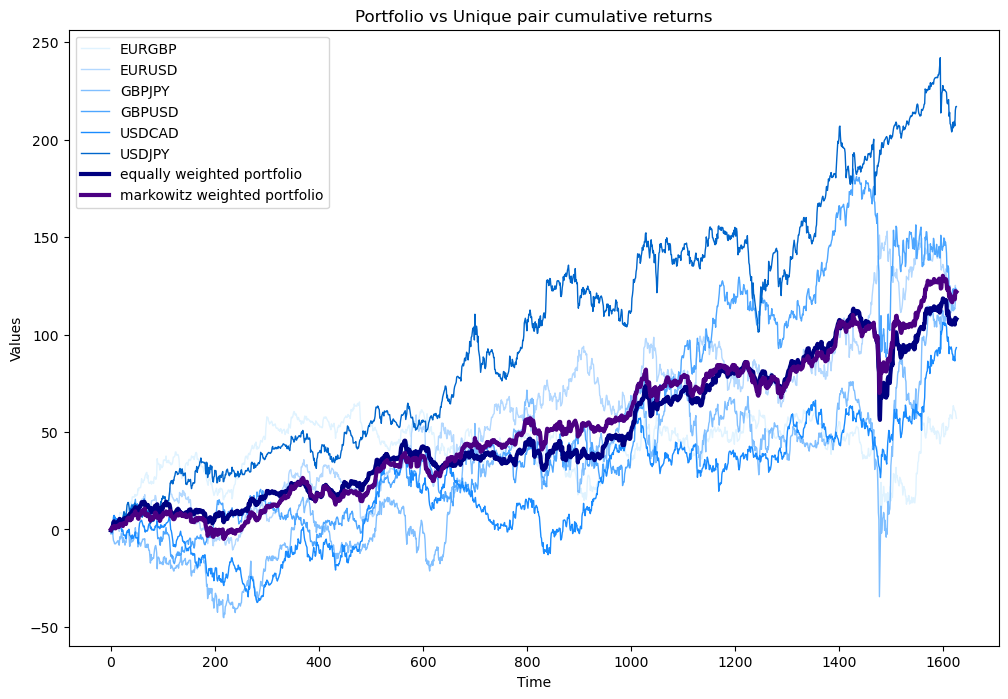

In [20]:
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8-deep')
colors = ["#e0f3ff", "#b3d8ff", "#80bfff", "#4da6ff", "#1a8cff", "#0066cc"]
for color, series in zip(colors, backtest_returns):
    plt.plot(backtest_returns[series].cumsum().values, label=series, color=color, lw=1)    
plt.plot(markowitz_pf_returns.cumsum().values, label='equally weighted portfolio', color='navy', lw=3)
plt.plot(equaly_weighted_pf_returns.cumsum().values, label='markowitz weighted portfolio', color='indigo', lw=3)
plt.title('Portfolio vs Unique pair cumulative returns')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

In [38]:
import sqlite3
conn = sqlite3.connect('datas.db')

markowitz_pf_returns.to_sql('markowitz_pf_returns', conn, if_exists='replace', index=True)
equaly_weighted_pf_returns.to_sql('equaly_weighted_pf_returns', conn, if_exists='replace', index=True)

1813